In [27]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, glob, os
import scipy.stats as stats, scipy.io as sio
from scipy.ndimage import gaussian_filter1d
from neo.io import BlackrockIO
from nilearn import datasets, plotting

In [48]:
patient = 12

### create QC file

In [49]:
df_rows = []
# to get channel & unit IDs
fig_files = glob.glob(f'../../results/2025{patient}/osort_mat/figs/5/*')

for fig_file in sorted(fig_files):

    # skip raw fig files, and all-unit fig files
    if 'CL' not in fig_file or 'ALL' in fig_file: continue
    
    chanID = int(os.path.basename(fig_file).split('_')[0][1:])
    unitID = int(os.path.basename(fig_file).split('_')[2])
    df_rows.append((chanID, unitID))

# sort properly by channel then unit
df_rows_sorted = sorted(df_rows, key=lambda x: (x[0], x[1]))
    
chanID_df = pd.DataFrame(df_rows_sorted, columns=['chanID', 'unitID'])
chanID_df.to_csv(f'../../results/2025{patient}/records/chanID_pt{patient}.csv', index=False)
chanID_df

,chanID,unitID
0,97,596
1,97,612
2,98,1432
3,98,1502
4,98,1543
...,...,...
85,126,156
86,127,182
87,127,188
88,128,167


### perform manual QC. then load:

In [50]:
QC_df = pd.read_csv(f'../../results/2025{patient}/records/QC_pt{patient}.csv')

# clean
QC_df['keep'] = QC_df['keep'].fillna(0)
dropped_clustIDs = QC_df[QC_df['keep'] != 1]['unitID'].astype(int).tolist()
dropped_clustIDs.extend([0, 1, 99999999])
QC_df = QC_df[~QC_df['unitID'].isin(dropped_clustIDs)].copy().reset_index(drop=True)

QC_df

,chanID,unitID,keep,notes
0,97,612,1.0,isolation
1,98,1583,1.0,NaN
2,99,703,1.0,NaN
3,100,683,1.0,isolation
4,101,952,1.0,NaN
5,102,2460,1.0,NaN
6,102,2475,1.0,isolation
7,102,2477,1.0,NaN
8,103,1466,1.0,isolation
9,104,2349,1.0,isolation


In [51]:
def getclustID2spikes(clustIDs, spikes):
    ''' return dict with keys=unique clusters, and vals = list of corresponding spikes '''
    
    dropped_clustIDs.extend([0, 1, 99999999])  # also drop these
    clust2spikes = {}
    for clustID, spike in zip(clustIDs, spikes):

        if clustID in dropped_clustIDs: continue

        if clustID not in clust2spikes: clust2spikes[clustID] = [] # init

        clust2spikes[clustID].append(spike)

    return clust2spikes

### create initial df with chanID, clustID, spikes, #spikes, avgFR
 

In [52]:
samp_rate = 1000000
neur_spikes_df = []

# go through OSort mat files
for mat_file in glob.glob(f'../../results/2025{patient}/osort_mat/sort/5/*_sorted_new.mat'):

    chan_mat = sio.loadmat(mat_file)

    chanID = int(os.path.basename(mat_file).split('_')[0][1:])  # A198_sorted_new.mat -> 198
    clustIDs = chan_mat['assignedNegative'][0] # len = total n_spikes
    spikes = chan_mat['newTimestampsNegative'][0] # len = total n_spikes
    # clust_spikes_df = pd.DataFrame({'clustID': clustIDs, 'spike': spikes})

    # create dict:  clustID => [spikes], retaining only QCed units
    clust2spikes = getclustID2spikes(clustIDs, spikes) # len = # unique QCed clustIDs

    # 1 row per QCed clustID
    clust_df = pd.DataFrame([
        {
            "chanID": chanID,
            "clustID": clustID,
            "spikes": np.array(spikes)/samp_rate, #[spike/samp_rate for spike in spikes],
            "#spikes": len(spikes),
            "avgFR": len(spikes) / ((spikes[-1] - spikes[0]) / samp_rate),
        }
        for clustID, spikes in clust2spikes.items()
    ])
    neur_spikes_df.append(clust_df)

neur_spikes_df = pd.concat(neur_spikes_df, ignore_index=True)
# sort by chanID and then clustID
neur_spikes_df = neur_spikes_df.sort_values(by=['chanID', 'clustID']).reset_index(drop=True)
neur_spikes_df


,chanID,clustID,spikes,#spikes,avgFR
0,97,612,"[18.085633333333337, 23.6378, 25.1716666666666...",1062,0.670538
1,98,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888
2,99,703,"[17.702133333333336, 21.486933333333337, 22.60...",888,0.560458
3,100,683,"[20.34896666666667, 21.30346666666667, 25.8843...",1044,0.652937
4,101,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957
5,102,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268
6,102,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609
7,102,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394
8,103,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596
9,104,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847


In [53]:
# print lens of clustIDs in both dfs
print(f'len QC_df clustIDs: {len(QC_df["unitID"].unique())}')
print(f'len neur_spikes_df clustIDs: {len(neur_spikes_df["clustID"].unique())}')

# instead, for every channel, print clustIDs that are in QC_df but not in neur_spikes_df
for chanID in QC_df['chanID'].unique():
    qc_clustIDs = set(QC_df[QC_df['chanID'] == chanID]['unitID'])
    neur_clustIDs = set(neur_spikes_df[neur_spikes_df['chanID'] == chanID]['clustID'])
    missing_clustIDs = qc_clustIDs - neur_clustIDs
    if missing_clustIDs:
        print(f'chanID {chanID} missing clustIDs: {missing_clustIDs}')

len QC_df clustIDs: 33
len neur_spikes_df clustIDs: 33


### channel -> region -> index -> coordinates (-> atlas regions?)

In [54]:
# channels -> regions
channelInfo = sio.loadmat(f'../../results/2025{patient}/records/2025{patient}_DI_ChannelMap.mat')

if patient == 12: channelMap = channelInfo['ChannelMap1'].flatten()
elif patient == 18: channelMap = channelInfo['ChannelMap2'].flatten()

labelMap = channelInfo['LabelMap'].flatten() # contains region labels
labelMap = np.array([str(label.squeeze()) for label in labelMap])  # convert to str

# dict after removing nan keys
nan_mask = ~np.isnan(channelMap)
channel2label = dict(zip(channelMap[nan_mask], labelMap[nan_mask]))

neur_spikes_df['region'] = neur_spikes_df['chanID'].map(channel2label).fillna(neur_spikes_df['chanID']).apply(lambda x: str(x))
print(neur_spikes_df['region'].unique())


['mLOFC1' 'mLOFC2' 'mLOFC3' 'mLOFC4' 'mLOFC5' 'mLOFC6' 'mLOFC7' 'mLOFC8'
 'mLACC1' 'mLACC2' 'mLACC3' 'mLACC4' 'mLACC5' 'mLACC6' 'mLACC7' 'mLACC8'
 'mRHIP1' 'mRHIP2' 'mRHIP3' 'mRHIP4' 'mRHIP5' 'mRHIP6' 'mRHIP8']


In [55]:
# regions -> coords

def clean_entry(x):
    while isinstance(x, (np.ndarray, list)):
        x = x[0]
    if isinstance(x, (bytes, bytearray)):
        x = x.decode("utf-8", errors="ignore")
    return str(x)

# load
electrodeInfo = sio.loadmat(f'../../results/2025{patient}/records/2025{patient}_DI_Electrodes.mat')
ElecMapRaw   = pd.DataFrame(electrodeInfo['ElecMapRaw']) # region -> ID
ElecXYZRaw   = pd.DataFrame(electrodeInfo['ElecXYZRaw']) # ID -> coordinates
ElecAtlasRaw = pd.DataFrame(electrodeInfo['ElecAtlasRaw']) # atlas coords?

atlas_index = 0 # NMM

# clean
region_s = ElecMapRaw[0].apply(clean_entry)                    # Series of regions
atlas_s  = ElecAtlasRaw.iloc[:, atlas_index].apply(clean_entry)  # Series of atlas regions

# build small tables
region2id_df = pd.DataFrame({"region": region_s.values,
                             "ID": np.arange(len(region_s))})
id2xyz_df = ElecXYZRaw.reset_index().rename(columns={'index':'ID', 0:'x', 1:'y', 2:'z'})
# xyz2atlasRegions = pd.DataFrame({"ID": np.arange(len(atlas_s)),
#                                  "atlas_region": atlas_s.values})

# merge
final_neur_df = (neur_spikes_df
                .merge(region2id_df, on='region', how='left')
                .merge(id2xyz_df, on='ID', how='left')
                # .merge(xyz2atlasRegions, on='ID', how='left')
                )
final_neur_df = final_neur_df.drop(columns=['ID'])

### inspect

In [56]:
eg_spikes = final_neur_df['spikes'].iloc[0]
print(f'last 5 spikes (s): {eg_spikes[-5:]}')
print(f'last 5 spikes (min): {eg_spikes[-5:]/60}')
n_neurs = len(final_neur_df)
final_neur_df

last 5 spikes (s): [1599.64183333 1600.6705     1600.95396667 1601.53736667 1601.88753333]
last 5 spikes (min): [26.66069722 26.67784167 26.68256611 26.69228944 26.69812556]


,chanID,clustID,spikes,#spikes,avgFR,region,x,y,z
0,97,612,"[18.085633333333337, 23.6378, 25.1716666666666...",1062,0.670538,mLOFC1,-0.111605,40.172309,-15.682235
1,98,1583,"[4.070566666666667, 12.215633333333335, 12.364...",5454,3.372888,mLOFC2,-0.111605,42.570655,-15.682235
2,99,703,"[17.702133333333336, 21.486933333333337, 22.60...",888,0.560458,mLOFC3,-0.111605,41.371482,-15.682235
3,100,683,"[20.34896666666667, 21.30346666666667, 25.8843...",1044,0.652937,mLOFC4,-1.311382,40.172309,-15.682235
4,101,952,"[18.244333333333337, 20.953133333333337, 21.33...",1865,1.176957,mLOFC5,-1.311382,42.570655,-15.682235
5,102,2460,"[2.2395, 2.7039, 17.368133333333336, 18.0163, ...",5565,3.437268,mLOFC6,-2.511159,42.570655,-15.682235
6,102,2475,"[21.893966666666667, 23.410966666666667, 32.29...",2432,1.520609,mLOFC6,-2.511159,42.570655,-15.682235
7,102,2477,"[18.131033333333335, 18.393666666666668, 18.54...",10843,6.764394,mLOFC6,-2.511159,42.570655,-15.682235
8,103,1466,"[17.218533333333337, 18.210833333333337, 18.42...",3834,2.406596,mLOFC7,-2.511159,40.172309,-15.682235
9,104,2349,"[5.8953, 13.255100000000002, 17.28773333333333...",8883,5.499847,mLOFC8,-2.511159,41.371482,-15.682235


## plot electrode location

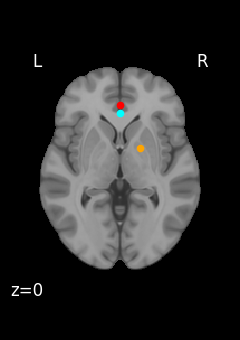

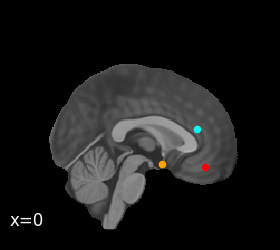

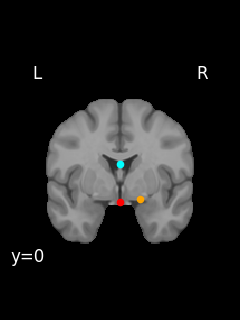

{'OFC': 'red', 'ACC': 'cyan', 'HIP': 'orange'}


In [58]:
template = datasets.load_mni152_template()

# grab most distal channels for each electrode
# IDs were different for older recording system (pt12)
if patient == 12: plot_chanIDs = [97, 105, 113]
else: plot_chanIDs = [193, 202, 210]

coords_list = []
for ch in plot_chanIDs:
    row = final_neur_df[final_neur_df['chanID'] == ch].iloc[0]   # first match
    coords_list.append([row.x, row.y, row.z])

coords = np.array(coords_list)

coord_regions  = ['OFC', 'ACC', 'HIP']
colors = {'OFC':'red', 'ACC':'cyan', 'HIP':'orange'}
marker_size = 20
# x = sagittal, y = coronal, z = axial

# 1. axial
# fix z (axial)
axial_cut = 0
coords_ax = coords.copy()
coords_ax[:,2] = axial_cut
disp1 = plotting.plot_anat(template, display_mode='z', cut_coords=[axial_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_ax, coord_regions):
    disp1.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])
    
# 2. sagittal (x=0)
sag1_cut = 0
coords_sag1 = coords.copy()
coords_sag1[:,0] = sag1_cut
disp2 = plotting.plot_anat(template, display_mode='x', cut_coords=[sag1_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_sag1, coord_regions):
    disp2.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

# 3. coronal (y=30)
cor_cut = 0
coords_cor = coords.copy()
coords_cor[:,1] = cor_cut
disp4 = plotting.plot_anat(template, display_mode='y', cut_coords=[cor_cut],
                           cmap='gray', black_bg=True, draw_cross=False, colorbar=False)
for (x,y,z), name in zip(coords_cor, coord_regions):
    disp4.add_markers([(x,y,z)], marker_size=marker_size, marker_color=colors[name])

plotting.show()

print(colors)

### clean_trigs_df with trig times from .nev

In [59]:
# load

nev_file = glob.glob(f'../../results/2025{patient}/raw/*.nev')[0]
nev_file = glob.glob(f'../../results/202512/raw/*.nev')[0]
io = BlackrockIO(nev_file)
seg = io.read_block(lazy=False).segments[0]
dig_ev = [ev for ev in seg.events if "digital" in ev.name.lower()][0]

# map codes to labels
code_map = {
    10: "block started",
    20: "baseline started",
    30: "stim started",
    40: "delay started",
    50: "task started",
    51: "marker moved",
    52: "left pressed",
    53: "left released",
    54: "right pressed",
    55: "right released",
    56: "response submitted",
    60: "anticipation started",
    70: "feedback started",
    80: "block ended",
}

# build df
df_trigs = pd.DataFrame({
    "trigger": dig_ev.labels.astype(int),
    "time": dig_ev.times.magnitude
})
df_trigs["event"] = df_trigs["trigger"].map(code_map)

clean_trigs_df = df_trigs[3:]
print(clean_trigs_df.head(15))


    trigger       time                 event
3        10  36.379967         block started
4        20  70.978933      baseline started
5        30  71.864133          stim started
6        40  72.858367         delay started
7        50  74.342867          task started
8        51  75.375000          marker moved
9        52  75.375133          left pressed
10       53  75.974967         left released
11       56  76.374967    response submitted
12       60  76.375833  anticipation started
13       70  76.624967      feedback started
14       20  77.625233      baseline started
15       30  78.609500          stim started
16       40  79.608367         delay started
17       50  81.044033          task started


In [60]:
# checks
n_blocks = sum(clean_trigs_df['event'] == 'block started')
n_stim = sum(clean_trigs_df['event'] == 'stim started')
n_delay = sum(clean_trigs_df['event'] == 'delay started')
n_task = sum(clean_trigs_df['event'] == 'task started')
n_feedback = sum(clean_trigs_df['event'] == 'feedback started')
print(n_blocks, n_stim, n_delay, n_task, n_feedback)


6 240 240 240 240


### subj_df with psychopy trial info

In [61]:
pts_df = pd.read_csv('../../results/psychopy/all_subjs_clean.csv')
pt_df = pts_df.loc[pts_df['subj'] == str(patient)].reset_index(drop=True)
pt_df

,dir_flip,sess_flip,chosen_pos_aligned,div_pos_aligned,stim_pos_aligned,true_class,pred_class,err_type,invalid,missed,...,Mcross.started,Mcross.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Unnamed: 122,Unnamed: 115,stim_ranks,resp_ranks
0,1.0,0.0,0.364,-0.0,0.02,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21.5,38.0
1,1.0,0.0,0.352,-0.0,0.30,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.5,37.0
2,0.0,0.0,0.284,0.0,0.14,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.5,33.0
3,1.0,0.0,-0.280,-0.0,-0.30,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.5,9.0
4,1.0,0.0,0.304,-0.0,0.34,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.5,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0.0,0.0,0.260,0.2,0.30,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.5,25.0
236,1.0,0.0,0.124,0.2,-0.18,0,0,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,15.0
237,1.0,0.0,0.252,0.2,0.38,1,1,0,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.5,23.5
238,1.0,0.0,0.320,0.2,0.14,0,1,1,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.5,37.0


In [62]:
pt_df['uncertainty'].value_counts()
pt_base = pt_df[pt_df['condition'] == 'baseline']
pt_gain_exp = pt_df[pt_df['condition'] == 'rew_comp']
pt_loss_exp = pt_df[pt_df['condition'] == 'pen_comp']
pt_base['uncertainty'].value_counts(), pt_gain_exp['uncertainty'].value_counts(), pt_loss_exp['uncertainty'].value_counts()

(uncertainty
 False    64
 True     16
 Name: count, dtype: int64,
 uncertainty
 False    48
 True     32
 Name: count, dtype: int64,
 uncertainty
 False    48
 True     32
 Name: count, dtype: int64)

## get spikes & rates per trial & neuron

In [63]:
# bin params
size, dt = .02, .001

# phase prestarts and ends
phases = ['baseline', 'stim', 'delay', 'task', 'feedback']
phase_prestarts, phase_ends = {}, {}

# plotting -1 from response submission ('task')
for phase in phases: phase_prestarts[phase] = -1 if phase == 'task' else -.25
# plotting until entire duration (1.5 for delay, and 1s for the others)
# but only plotting until response submission for 'task' 
for phase in phases: phase_ends[phase] = 1.5 if phase == 'delay' else (0 if phase == 'task' else 1)

def get_normed_FRs(FRs, base_FRs):
    return FRs / base_FRs.mean(axis=(0, 2), keepdims=True)

def get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, phase, size=size, dt=dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in phase window
        clean_trigs_df: trig times 
        final_neur_df: spike times per neur '''

    phase_prestart = phase_prestarts[phase]
    phase_end = phase_ends[phase]

    # bin edges & centers for hists & plots
    bin_edges = np.arange(phase_prestart, phase_end + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & phase_end edges
    n_bins = len(bin_edges) - 1

    # a. get 240 start times of this phase
    phase_start_rows = clean_trigs_df[clean_trigs_df['event'] == f'{phase} started'].index
    phase_starts = clean_trigs_df.loc[phase_start_rows, 'time'].values
    assert len(phase_starts) == 240

    # b. get 240 stop times of response, which is marked by 'anticipation started'
    resp_end_rows = clean_trigs_df[clean_trigs_df['event'] == f'anticipation started'].index
    resp_ends = clean_trigs_df.loc[resp_end_rows, 'time'].values
    assert len(resp_ends) == 240

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.empty((len(phase_starts), len(final_neur_df)), dtype=object)
    trial_neur_FRs = np.zeros((len(phase_starts), len(final_neur_df), n_bins))

    for trial_idx in range(len(phase_starts)):

        for neur_idx, (_, neur_row) in enumerate(final_neur_df.iterrows()):

            spike_train = np.zeros(n_bins)

            # 1. spikes within epoch

            if phase != 'task': # align to onset
                trial_phase_spikes = neur_row['spikes'][(neur_row['spikes'] >= phase_starts[trial_idx] + phase_prestart) &
                                                        (neur_row['spikes'] <= phase_starts[trial_idx] + phase_end)]          
                trial_phase_spikes = trial_phase_spikes - phase_starts[trial_idx] # align
            else: # align to offset, which is the onset of anticipation
                trial_phase_spikes = neur_row['spikes'][(neur_row['spikes'] >= resp_ends[trial_idx] + phase_prestart) &
                                                        (neur_row['spikes'] <= resp_ends[trial_idx] + phase_end)]          
                trial_phase_spikes = trial_phase_spikes - resp_ends[trial_idx] # align

            # 2. FRs within epoch
            # histogram counts → Hz
            counts, _ = np.histogram(trial_phase_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt
            # smooth
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)

            # finally, store
            trial_neur_spikes[trial_idx, neur_idx] = trial_phase_spikes
            trial_neur_FRs[trial_idx, neur_idx, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

# baseline spikes/FRs for norming
base_spikes, base_FRs, bin_centers = get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, 'baseline')

In [99]:
print("base_spikes: (trial * neurs):", base_spikes.shape)
print("base_FRs: (trial * neurs * bins):", base_FRs.shape)

# print 3 example spike trains and FRs for random trial and neur
for rand_trial, rand_neur in zip(np.random.randint(0, base_spikes.shape[0], size=3),
                                 np.random.randint(0, base_spikes.shape[1], size=3)):
    print(f'\ntrial {rand_trial}, neur {rand_neur}:')
    print(f"spikes", base_spikes[rand_trial, rand_neur])
    print(f"FRs", base_FRs[rand_trial, rand_neur])

base_spikes: (trial * neurs): (240, 33)
base_FRs: (trial * neurs * bins): (240, 33, 1250)

trial 69, neur 5:
spikes [-0.21783333 -0.21263333 -0.16683333 -0.15573333  0.29593333  0.3186
  0.47803333  0.51976667  0.58136667  0.84333333  0.84596667]
FRs [17.587004   17.67404489 17.84748855 ...  0.          0.
  0.        ]

trial 228, neur 2:
spikes [0.43113333]
FRs [0. 0. 0. ... 0. 0. 0.]

trial 116, neur 1:
spikes [-0.00126667  0.0041      0.3869      0.39283333  0.58326667  0.91153333]
FRs [0. 0. 0. ... 0. 0. 0.]


In [93]:
# now for FR
print("base_FRs: (trial * neurs * bins):", base_FRs.shape)
# print 5 example spike trains for random trial and neur
for rand_trial, rand_neur in zip(np.random.randint(0, base_FRs.shape[0], size=5),
                                 np.random.randint(0, base_FRs.shape[1], size=5)):
    print(f"trial {rand_trial}, neur {rand_neur}:", base_FRs[rand_trial, rand_neur])

base_FRs: (trial * neurs * bins): (240, 33, 1250)
trial 74, neur 25: [0. 0. 0. ... 0. 0. 0.]
trial 210, neur 13: [49.70575568 49.67091762 49.60174328 ...  0.          0.
  0.        ]
trial 38, neur 14: [1.11943932 1.13664973 1.17114877 ... 0.         0.         0.        ]
trial 50, neur 26: [0. 0. 0. ... 0. 0. 0.]
trial 59, neur 7: [0.         0.         0.         ... 0.8954629  0.86683808 0.85256826]


In [66]:
def get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, trial_half, size=size, dt=dt):
    ''' for each trial and neuron, get spike times and smoothed FRs (Hz) in phase window
        clean_trigs_df: trig times 
        final_neur_df: spike times per neur '''
    
    if trial_half == '1st':
        phase = 'stim'
        phase_prestart = -.25 # considers last .25s of baseline and 1 + 1.5s + 1s of stim + delay + response
        phase_end = 3.5
    elif trial_half == '2nd':
        phase = 'feedback'
        phase_prestart = -1.25 # considers last 1s of response and .25 anticipation
        phase_end = 1
    else:
        raise ValueError("trial_half must be '1st' or '2nd'")

    # bin edges & centers for hists & plots
    bin_edges = np.arange(phase_prestart, phase_end + dt, dt)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2 # avg of start & phase_end edges
    n_bins = len(bin_edges) - 1

    # get 240 start times of this phase
    phase_start_rows = clean_trigs_df[clean_trigs_df['event'] == f'{phase} started'].index
    phase_starts = clean_trigs_df.loc[phase_start_rows, 'time'].values
    assert len(phase_starts) == 240

    # 3d arr for spikes_times and binned_FRs
    trial_neur_spikes = np.empty((len(phase_starts), len(final_neur_df)), dtype=object)
    trial_neur_FRs = np.zeros((len(phase_starts), len(final_neur_df), n_bins))

    for trial_idx in range(len(phase_starts)):

        for neur_idx, (_, neur_row) in enumerate(final_neur_df.iterrows()):

            spike_train = np.zeros(n_bins)

            # 1. spikes within epoch

            trial_phase_spikes = neur_row['spikes'][(phase_starts[trial_idx] + phase_prestart <= neur_row['spikes']) &
                                                    (neur_row['spikes']                       <= phase_starts[trial_idx] + phase_end)]          
            trial_phase_spikes = trial_phase_spikes - phase_starts[trial_idx] # align

            # 2. FRs within epoch
            # histogram counts → Hz
            counts, _ = np.histogram(trial_phase_spikes, bins=bin_edges)
            spike_train = counts.astype(float) / dt
            # smooth
            smooth_spike_train = gaussian_filter1d(spike_train, sigma=size/dt, mode='reflect', truncate=3.0)

            # finally, store
            trial_neur_spikes[trial_idx, neur_idx] = trial_phase_spikes
            trial_neur_FRs[trial_idx, neur_idx, :] = smooth_spike_train

    return trial_neur_spikes, trial_neur_FRs, bin_centers

## create contrasts

In [ ]:
def get_contrast_in_phase(clean_trigs_df, final_neur_df, subj_df, phase, contrast):
    ''' for particular contrast, in a particular phase, draw out spikes & FRs
        clean_trigs_df: trig times
        final_neur_df: spike times
        subj_df: trial info '''
    
    print(f'contrast: {contrast}, phase: {phase}')

    # get spikes/FRs for all trials/neurons in this phase
    spikes, FRs, bin_centers = get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, phase, size, dt)

    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, 'first_half', size, dt)
    # spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, 'second_half', size, dt)

    # storing trials and labels for each contrast
    cont_trials, cont_labels = [], []

    # stim contrasts
    if contrast =='context':
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
        cont_labels.append('gain')
        cont_labels.append('loss')
    # elif contrast =='stim':
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
    #     cont_labels.append('flat (curv) stims')
    #     cont_labels.append('curv (flat) stims')
    elif contrast =='difficulty':
        cont_trials.append(subj_df[~subj_df['difficulty']].index)
        cont_trials.append(subj_df[subj_df['difficulty']].index)
        cont_labels.append('easy')
        cont_labels.append('hard')

    # choice contrasts (median splits)
    elif contrast == 'resp_dir':
        cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
        cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
        cont_labels.append('right')
        cont_labels.append('left')
    elif contrast == 'normed_RT':
        median_rt = subj_df['normed_RT'].median()
        cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
        cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
        cont_labels.append('fast')
        cont_labels.append('slow')
    # elif contrast == 'dir_flip':
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
    #     cont_labels.append('not flipped')
    #     cont_labels.append('flipped')


    # outcome contrasts
    elif contrast == 'outcome':
        cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
        cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
        cont_labels.append('3 coins')
        cont_labels.append('1 coin')
        cont_labels.append('-1 coin')
        cont_labels.append('-3 coins')

    # condition contrast
    elif contrast == 'conditions':
        cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('gain_expanded')
        cont_labels.append('loss_expanded')
        cont_labels.append('baseline')
    elif contrast == 'baseline vs compressed conditions':
        cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('comp')
        cont_labels.append('base')

    # err
    else:
        raise ValueError('Invalid contrast')

    print('#trials should typically be 240/#contrasts')

    print('spikes (#trials, #neurs)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
    print('rates (#trials, #neurs, #bins)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

    return spikes, FRs, bin_centers, cont_trials, cont_labels


In [ ]:
def get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast):
    ''' for particular contrast, in a particular phase, draw out spikes & FRs
        clean_trigs_df: trig times
        final_neur_df: spike times
        subj_df: trial info '''
    
    print(f'contrast: {contrast}, trial_half: {trial_half}')

    # get spikes/FRs for all trials/neurons in this trial_half
    spikes, FRs, bin_centers = get_trial_spikes_and_FRs(clean_trigs_df, final_neur_df, trial_half, size, dt)

    # storing trials and labels for each contrast
    cont_trials, cont_labels = [], []

    # stim contrasts
    if contrast =='context':
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > subj_df['div_pos_aligned']].index)
        cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < subj_df['div_pos_aligned']].index)
        cont_labels.append('gain')
        cont_labels.append('loss')
    # elif contrast =='stim':
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] > .0].index)
    #     cont_trials.append(subj_df[subj_df['stim_pos_aligned'] < -.0].index)
    #     cont_labels.append('flat (curv) stims')
    #     cont_labels.append('curv (flat) stims')
    elif contrast =='difficulty':
        cont_trials.append(subj_df[~subj_df['difficulty']].index)
        cont_trials.append(subj_df[subj_df['difficulty']].index)
        cont_labels.append('easy')
        cont_labels.append('hard')

    # choice contrasts (median splits)
    elif contrast == 'resp_dir':
        cont_trials.append(subj_df[subj_df['chosen_pos'] > subj_df['div_pos']].index)
        cont_trials.append(subj_df[subj_df['chosen_pos'] < subj_df['div_pos']].index)
        cont_labels.append('right')
        cont_labels.append('left')
    elif contrast == 'normed_RT':
        median_rt = subj_df['normed_RT'].median()
        cont_trials.append(subj_df[subj_df['normed_RT'] <= median_rt].index)
        cont_trials.append(subj_df[subj_df['normed_RT'] > median_rt].index)
        cont_labels.append('fast')
        cont_labels.append('slow')
    # elif contrast == 'dir_flip':
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 0].index)
    #     cont_trials.append(subj_df[subj_df['dir_flip'] == 1].index)
    #     cont_labels.append('not flipped')
    #     cont_labels.append('flipped')


    # outcome contrasts
    elif contrast == 'outcome':
        cont_trials.append(subj_df[subj_df['outcome'] == 3].index)
        cont_trials.append(subj_df[subj_df['outcome'] == 1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -1].index)
        cont_trials.append(subj_df[subj_df['outcome'] == -3].index)
        cont_labels.append('3 coins')
        cont_labels.append('1 coin')
        cont_labels.append('-1 coin')
        cont_labels.append('-3 coins')

    # condition contrast
    elif contrast == 'conditions':
        cont_trials.append(subj_df[subj_df['condition'] == 'pen_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'rew_comp'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('gain_expanded')
        cont_labels.append('loss_expanded')
        cont_labels.append('baseline')
    elif contrast == 'baseline vs compressed conditions':
        cont_trials.append(subj_df[subj_df['condition'] != 'baseline'].index)
        cont_trials.append(subj_df[subj_df['condition'] == 'baseline'].index)
        cont_labels.append('comp')
        cont_labels.append('base')

    # err
    else:
        raise ValueError('Invalid contrast')

    print('#trials should typically be 240/#contrasts')

    print('spikes (#trials, #neurs)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {spikes[cont_trials[contrast_idx], :].shape}')
    
    print('rates (#trials, #neurs, #bins)')
    for contrast_idx in range(len(cont_labels)):
        print(f'\t{cont_labels[contrast_idx]}: {FRs[cont_trials[contrast_idx], :, :].shape}')

    return spikes, FRs, bin_centers, cont_trials, cont_labels


### plots

a. check rasters

In [ ]:
# phase = 'task'
# spikes, FRs, bin_centers = get_phase_spikes_and_FRs(clean_trigs_df, final_neur_df, phase, size, dt)
# normed_FRs = get_normed_FRs(FRs, base_FRs)

# n_rows, n_cols = 5, 5
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# for neur_id in range(n_neurs):
#     axs[ax].eventplot(spikes[:, neur_id], orientation='horizontal', colors='k', alpha=0.3, linewidths=1., linelengths=3.)
#     axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron, id={neur_id}',
#                 ylabel='trial', xlabel=f'time from {phase} onset (s)', xlim=[phase_prestarts[phase], phase_ends[phase]])
#     ax += 1

# plt.suptitle(phase, y=1.01, fontsize=16)
# plt.tight_layout()
# plt.show()


In [ ]:
# dropping neurons with missing trials for some reason
dropped_neur_ids = [9, 11, 17, 19, 21]

b. contrasts

In [ ]:
# phases = ['baseline', 'stim', 'task', 'delay', 'feedback']
# contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
phase, contrast = 'task', 'context'
spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_phase(clean_trigs_df, final_neur_df, subj_df, phase, contrast)
normed_FRs = get_normed_FRs(FRs, base_FRs)

NameError: name 'subj_df' is not defined

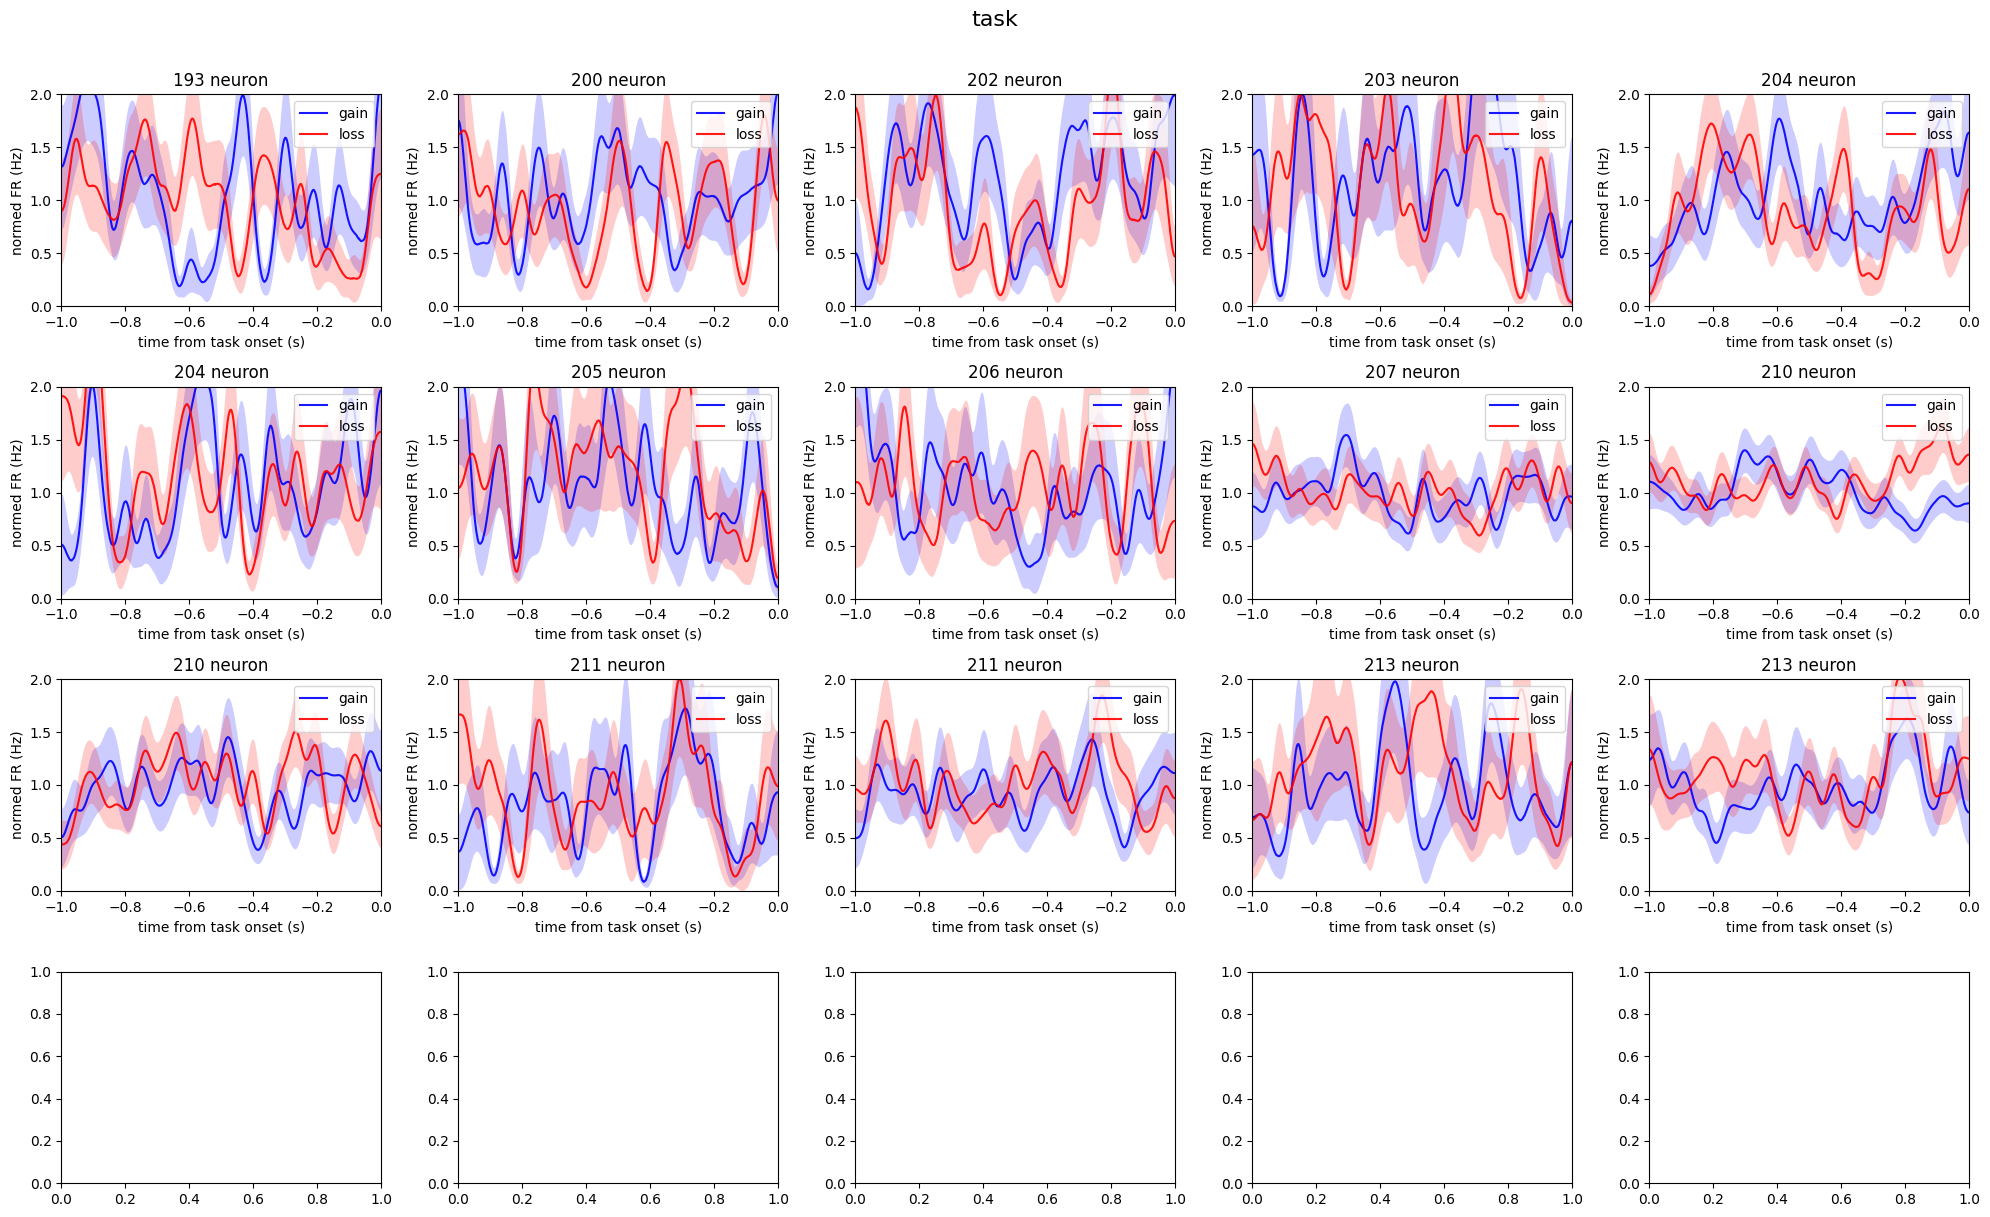

In [ ]:
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0
colors = ['b', 'r', 'g', 'k']

for neur_id in range(n_neurs):
    if neur_id in dropped_neur_ids: continue

    for idx in range(len(cont_labels)):

        cont_label, cont_trial, cont_color = cont_labels[idx], cont_trials[idx], colors[idx]

        data = normed_FRs[cont_trial, neur_id, :]

        mu = data.mean(axis=0)
        sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
        axs[ax].plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
        axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

    # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_id]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} onset (s)',
                xticks=np.linspace(phase_prestarts[phase], phase_ends[phase], 6), xlim=[phase_prestarts[phase], phase_ends[phase]], ylim=[0, 2])
    axs[ax].legend(loc='upper right')
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
# get unique rowID where region = 'mLACC5'. there might be multiple
reg = 'mLACC5'
neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]

# 1. raster
plt.figure(figsize=(4,3))
plt.title(f'{neur_spikes_df["region"].iloc[neur_id]} neuron')

# 1. raster
# create list of trials by contrast and corresponding color
raster_trial_list, color_trial_list = [], []
# for indx in range(len(cont_labels)):
for indx in [1,0]:
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
    raster_trial_list.extend(list(spikes[cont_trial, neur_id]))
    color_trial_list.extend([cont_color] * len(cont_trial))

plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.eventplot(raster_trial_list, orientation='horizontal', colors=color_trial_list, linewidths=1.0, linelengths=3.0)
plt.ylabel('sorted trials')
plt.xlabel(f'time from\n{phase} onset (s)')
plt.xlim([phase_prestarts[phase], phase_ends[phase]])
plt.show()

# 2. psth
plt.figure(figsize=(4,3))

for indx in range(len(cont_labels)):
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

    data = normed_FRs[cont_trial, neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    plt.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

plt.ylabel('normed FR (Hz)')
plt.xlabel(f'time from\n{phase} onset (s)')
plt.xlim([phase_prestarts[phase], phase_ends[phase]])
plt.ylim([.25, 1.75])
plt.legend(handles=[plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
                    for idx in range(len(cont_labels))], loc='upper right')
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

## sfn

In [ ]:
# phases = ['baseline', 'stim', 'task', 'delay', 'feedback']
# contrasts = ['context', 'stim', 'difficulty', 'outcome', 'conditions', 'baseline vs compressed conditions']
trial_half, contrast = '2nd', 'context'
spikes, FRs, bin_centers, cont_trials, cont_labels = get_contrast_in_trial(clean_trigs_df, final_neur_df, subj_df, trial_half, contrast)
normed_FRs = get_normed_FRs(FRs, base_FRs)

contrast: context, trial_half: 2nd
#trials should typically be 240/#contrasts
spikes (#trials, #neurs)
	gain: (120, 23)
	loss: (120, 23)
rates (#trials, #neurs, #bins)
	gain: (120, 23, 2250)
	loss: (120, 23, 2250)


In [ ]:
# get unique rowID where region = 'mLACC5'. there might be multiple
reg = 'mLACC5'
neur_id = neur_spikes_df[neur_spikes_df['region'] == reg].index[0]
colors = ['b', 'r', 'g', 'k']

# create figure with two subplots (stacked vertically)
width = 10 if trial_half == '1st' else 6
fig, axs = plt.subplots(2, 1, figsize=(width, 6), sharex=True,
                        gridspec_kw={'height_ratios': [1, 1]})  # equal height

# ---------------------------------------------
# 1. RASTER
# ---------------------------------------------
# --- Raster as dots instead of lines ---
ax = axs[0]

trial_counter = 0
for indx in [1, 0]:
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]
    
    for t_i, trial_idx in enumerate(cont_trial):
        spike_times = spikes[trial_idx, neur_id]
        ax.scatter(spike_times, 
                   np.ones_like(spike_times)*trial_counter, 
                   s=4, color=cont_color, alpha=.8)  # s = marker size
        trial_counter += 1

ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_ylabel('sorted trials')
if trial_half == '1st': ax.set_title('Aligned to stimulus')
elif trial_half == '2nd': ax.set_title('Aligned to outcome')

# ---------------------------------------------
# 2. PSTH
# ---------------------------------------------
ax = axs[1]
for indx in range(len(cont_labels)):
    cont_label, cont_trial, cont_color = cont_labels[indx], cont_trials[indx], colors[indx]

    data = normed_FRs[cont_trial, neur_id, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    ax.plot(bin_centers, mu, color=cont_color, alpha=0.9, label=cont_label)
    ax.fill_between(bin_centers, mu - sderr, mu + sderr, color=cont_color, alpha=0.2, linewidth=0)

ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_ylabel('normed FR (Hz)')
ax.set_ylim([0, 1.75])

# ax.set_xlabel(f'time from {phase} onset (s)')
if trial_half == '1st':
    ax.set_xlim([-.25, 3.5])
    for ax in axs:
        ax.axvline(1, color='k', linestyle='--', alpha=0.5) # end of response
        ax.axvline(2.5, color='k', linestyle='--', alpha=0.5) # end of response
elif trial_half == '2nd':
    ax.set_xlim([-1.25, 1])
    for ax in axs:
        ax.axvline(-.25, color='k', linestyle='--', alpha=0.5) # end of response

# legend
handles = [plt.Line2D([0], [0], color=colors[idx], lw=2, label=cont_labels[idx])
            for idx in range(len(cont_labels))]
ax.legend(handles=handles, loc='lower right')

for ax in axs:
    ax.tick_params(direction='in', length=4, width=1)
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
# fig.savefig('../../results/figs/sfn/fig4a_real_neur.eps', format='eps', dpi=300)
plt.rcParams['svg.fonttype'] = 'none'  # keeps text editable
fig.savefig(f'../../results/figs/sfn/fig4a_trial_{trial_half}_half.svg', format='svg', dpi=300)



IndexError: index 0 is out of bounds for axis 0 with size 0

c. phase neurons

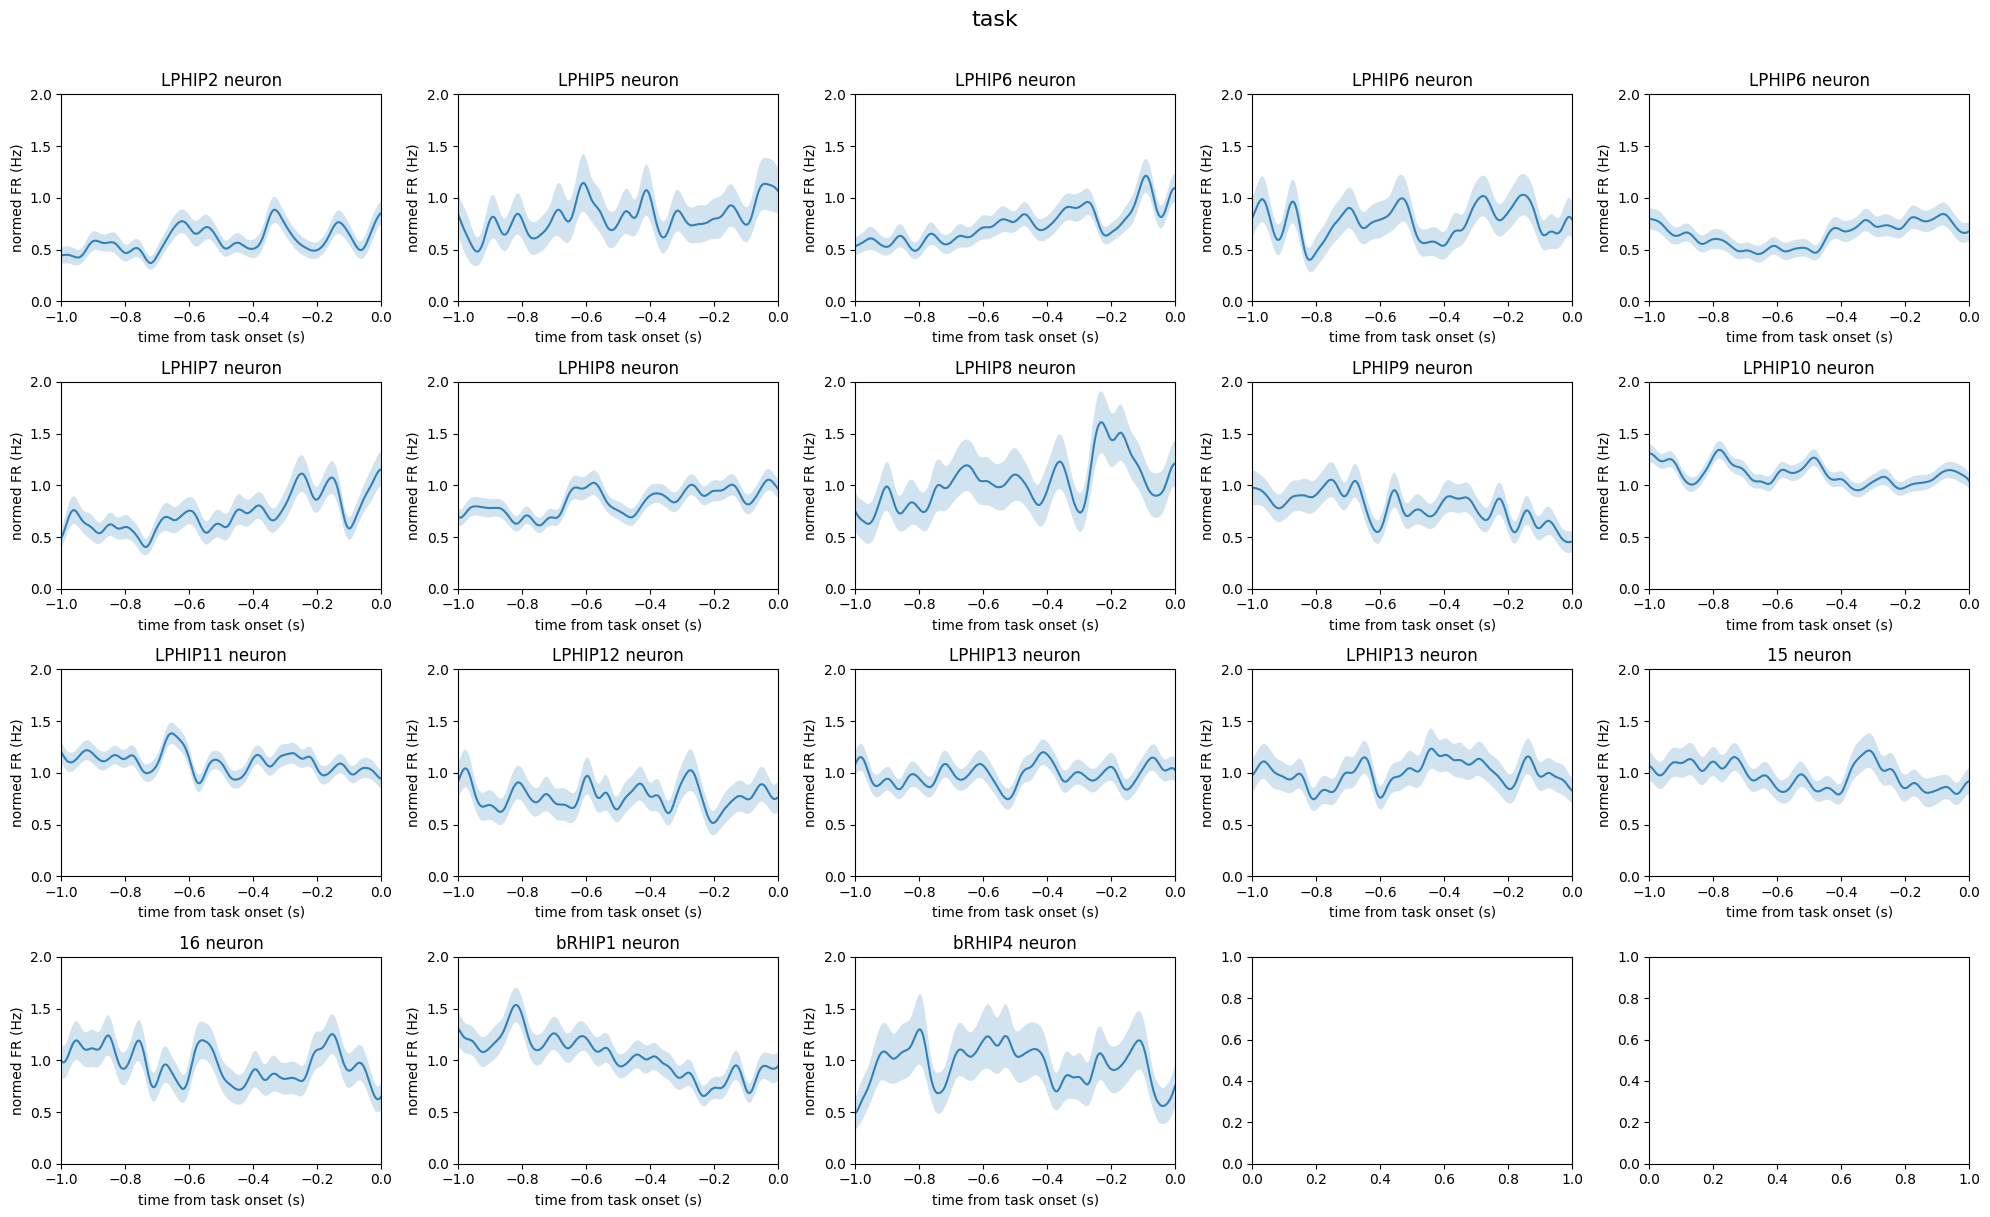

In [ ]:
n_rows, n_cols = 4, 5
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axs, ax = axs.flatten(), 0

for neur_i in range(n_neurs):

    if neur_i in dropped_neur_ids: continue
    # no norming for baseline itself
    data = normed_FRs[:, neur_i, :] if phase!='baseline' else FRs[:, neur_i, :]
    mu = data.mean(axis=0)
    sderr = (data.std(axis=0, ddof=1) / np.sqrt(data.shape[0])) if data.shape[0] > 1 else np.zeros_like(mu)
    axs[ax].plot(bin_centers, mu, alpha=0.9)
    axs[ax].fill_between(bin_centers, mu - sderr, mu + sderr, alpha=0.2, linewidth=0)
    # axs[ax].axvline(0, color='k', linestyle='--', alpha=0.5)
    axs[ax].set(title=f'{neur_spikes_df["region"].iloc[neur_i]} neuron', ylabel='normed FR (Hz)', xlabel=f'time from {phase} onset (s)',
                xticks=np.linspace(phase_prestarts[phase], phase_ends[phase], 6), xlim=[phase_prestarts[phase], phase_ends[phase]])
    if phase!='baseline': axs[ax].set(ylim=[0, 2])
    ax += 1

plt.suptitle(phase, y=1.01, fontsize=16)
plt.tight_layout()
plt.show()


zifest

In [ ]:
# plt.rcParams.update({
#     "axes.titlesize": 20,   # subplot titles
#     "axes.labelsize": 18,   # x/y labels
#     "xtick.labelsize": 16,  # x ticks
#     "ytick.labelsize": 16,  # y ticks
#     "legend.title_fontsize": 16,  # legend title
#     "legend.fontsize": 16,        # legend labels
# })

duration checks for stim & feedback

In [ ]:
# n_rows, n_cols = 1, 2
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
# axs, ax = axs.flatten(), 0

# print(len(subj_df['no_resp_text.started']))
# axs[ax].hist(subj_df['no_resp_text.started']-subj_df['feedback.started'], bins=30)
# axs[ax].set_title('no_resp_text.started - feedback.started (s)')
# ax += 1

# axs[ax].hist(subj_df['target_stim.started']-subj_df['stim.started'], bins=30)
# axs[ax].set_title('target_stim.started - stim.started (s)')

# plt.suptitle('duration checks')
# plt.tight_layout()
# plt.show()